In [1]:
import numpy as np
from glob import glob
import pandas as pd 
import SimpleITK as itk
from math import floor

from skimage import morphology, measure
from skimage.transform import resize

from time import sleep
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mhd_list = glob('./correct_images/*.mhd')
def find_file(name):
    for f in mhd_list:
        if f == './correct_images/{}.mhd'.format(name):
            return f
    return None

annotations = pd.read_csv('./csv/train/annotations.csv')
annotations['file'] = annotations['seriesuid'].apply(find_file)
annotations.dropna(inplace=True)

In [3]:
def draw(img, title='', point=None, diameter=None):
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='gray')
    if point is not None:
        plt.scatter(point[0], point[1],  c='w', s=diameter*10, edgecolors='r', alpha=0.2)
    plt.title(title)
    plt.show()

# Feature Engineering

In [4]:
def clean_img(img):
    mean, std = np.mean(img), np.std(img)
    img = (img - mean) / std
    
    mask = np.where(img>=0.5, 1.0, 0.0)
    mask = morphology.dilation(mask, np.ones([4, 4]))
#     draw(mask, title='dialation')
    mask = morphology.erosion(mask, np.ones([24, 24]))
#     draw(mask, title='erosion')
#     draw(img * (1-mask), title='img covered by mask')

    return img * (1-mask)

In [8]:
MAX_DIAM = 32 # for unet work
HALF_DIAM = int(MAX_DIAM / 2)

def get_3d_block(img_array, tumor, origin, spacing):
    pos = np.array([tumor['coordX'], tumor['coordY'], tumor['coordZ']])
    pos = np.round((pos - origin) / spacing)
    diameter = tumor['diameter_mm'] / spacing[0]
    
    x,y,z = int(-pos[0]), int(-pos[1]), int(pos[2])
    img_block = img_array[z-HALF_DIAM:z+HALF_DIAM]
    
    new_img_block = np.zeros((MAX_DIAM, 512, 512))
    mask_block = np.zeros((MAX_DIAM, 512, 512))
    
    for layer in range(MAX_DIAM):
        new_img_block[layer] = clean_img(img_block[layer]).copy()
        
        # mask
        v = abs(layer - HALF_DIAM)
        mask_block[layer, x-HALF_DIAM+v:x+HALF_DIAM-v, y-HALF_DIAM+v:y+HALF_DIAM-v] = 1.0
#         break
    
    return (new_img_block, mask_block)

In [16]:
all_blocks = []
all_mask = []

for f in mhd_list:
    print('processing {}'.format(f))
    itk_img = itk.ReadImage(f)
    origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
    spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
    img_array = itk.GetArrayFromImage(itk_img)
    
    tumors = annotations[annotations.file == f]
    for i in range(tumors.shape[0]):
        tumor = tumors.iloc[i]
        img_block, mask_block = get_3d_slice_pairs(img_array, tumor, origin, spacing)
#         print(img_array.shape, img_block.shape,mask_block.shape)
        
#         for z in range(MAX_DIAM):
#             draw(img_block[z], title='img_block[{}]'.format(z))
#             draw(mask_block[z], title='mask_block[{}]'.format(z))
#             break
        
        if img_block is not None and mask_block is not None:
            all_blocks.append(img_block)
            all_mask.append(mask_block)
            print('tumor {} done'.format(i+1))
            
#         break
#     break

X_train = np.reshape(all_blocks, (-1, 1, MAX_DIAM, 512, 512))
y_train = np.reshape(all_mask, (-1, 1, MAX_DIAM, 512, 512))

np.save('X_train_3d_cleaned', X_train)
np.save('y_train_3d_cleaned', y_train)

print("saved")

processing ./correct_images/LKDS-00052.mhd
tumor 1 done
tumor 2 done
tumor 3 done
tumor 4 done
tumor 5 done
tumor 6 done
processing ./correct_images/LKDS-00299.mhd
tumor 1 done
processing ./correct_images/LKDS-00359.mhd
tumor 1 done
processing ./correct_images/LKDS-00389.mhd
tumor 1 done
processing ./correct_images/LKDS-00390.mhd
tumor 1 done
processing ./correct_images/LKDS-00893.mhd
tumor 1 done
tumor 2 done
tumor 3 done
tumor 4 done
tumor 5 done
saved


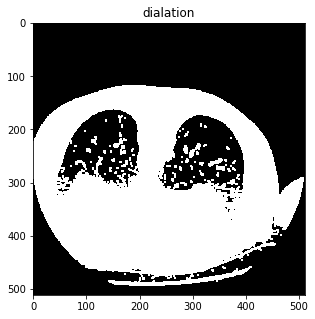

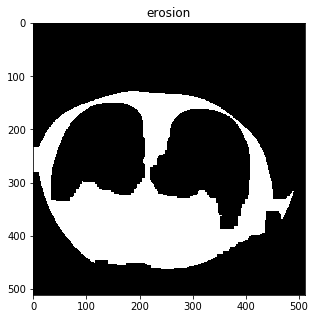

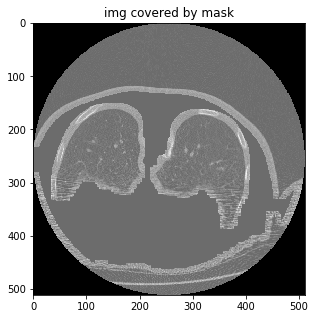

(array([[[-1.77096496, -1.77096496, -1.77096496, ..., -1.77096496,
          -1.77096496, -1.77096496],
         [-1.77096496, -1.77096496, -1.77096496, ..., -1.77096496,
          -1.77096496, -1.77096496],
         [-1.77096496, -1.77096496, -1.77096496, ..., -1.77096496,
          -1.77096496, -1.77096496],
         ..., 
         [-1.77096496, -1.77096496, -1.77096496, ..., -1.77096496,
          -1.77096496, -1.77096496],
         [-1.77096496, -1.77096496, -1.77096496, ..., -1.77096496,
          -1.77096496, -1.77096496],
         [-1.77096496, -1.77096496, -1.77096496, ..., -1.77096496,
          -1.77096496, -1.77096496]],
 
        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         ..., 
         [ 0.        ,  0.     

In [9]:
# let's draw and see
get_3d_block(img_array, tumor, origin, spacing)

# Train

In [17]:
from keras.models import Model
#from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K

K.set_image_dim_ordering('th')  # Theano dimension ordering in this code

img_rows = 512
img_cols = 512
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# def dice_coef_np(y_true,y_pred):
#     y_true_f = y_true.flatten()
#     y_pred_f = y_pred.flatten()
#     intersection = np.sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def get_unet():
    inputs = Input((1, MAX_DIAM, img_rows, img_cols))
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)

    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)

    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling3D(size=(2, 2, 2))(conv5), conv4], axis=1)
    conv6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling3D(size=(2, 2, 2))(conv6), conv3], axis=1)
    conv7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling3D(size=(2, 2, 2))(conv7), conv2], axis=1)
    conv8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling3D(size=(2, 2, 2))(conv8), conv1], axis=1)
    conv9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv3D(1, (1, 1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    model.compile(optimizer=Adam(lr=1.0e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model

model = get_unet()
model.summary()

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 32, 512, 51 0                                            
____________________________________________________________________________________________________
conv3d_1 (Conv3D)                (None, 32, 32, 512, 5 896         input_1[0][0]                    
____________________________________________________________________________________________________
conv3d_2 (Conv3D)                (None, 32, 32, 512, 5 27680       conv3d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling3d_1 (MaxPooling3D)   (None, 32, 16, 256, 2 0           conv3d_2[0][0]                   
___________________________________________________________________________________________

In [ ]:
model_checkpoint = ModelCheckpoint(filepath='unet-model-{epoch:02d}.hdf5', monitor='loss', verbose=1, save_best_only=True)
model.fit(X_train, y_train, batch_size=4, epochs=16, verbose=1, shuffle=True, callbacks=[model_checkpoint])

> However, it fails to train on a nvidia Tesla M40 GPU with 2G memory, since the tensor exceeds the memory limit.